# SmartLab project 3

The following paper compares a Fully Connected Network (FC) and a Convolutional Neural Network (CNN) in weather forecasting

### Import packages, magic commands

In [37]:
%matplotlib inline
%autosave 60

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
np.random.seed( 12)

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from keras.callbacks import Callback
from keras.optimizers import Adam
from sklearn import preprocessing

Autosaving every 60 seconds


### Data import

Below is the data import script but changed to comment because the [extracted csv file](https://drive.google.com/file/d/1i74iqIyODOz5iSrKTf7k3R1DqjMYausN/view?usp=sharing) is attached.
The source is [World Weather Online's Past local API](https://www.worldweatheronline.com/developer/api/historical-weather-api.aspx).

Contains 4 time-stamp variables which have been deleted because of standardization problem.
After dropping has 20 predictors in a 4138 day period.

In [2]:
# from wwo_hist import retrieve_hist_data

# frequency = 24
# start_date = '01-JUL-2008'
# end_date = '16-OCT-2019'
# api_key = ''
# location_list = ['budapest']

# hist_weather_data = retrieve_hist_data( api_key,
#                                location_list,
#                                start_date,
#                                end_date,
#                                frequency,
#                                location_label = False,
#                                export_csv = True,
#                                store_df = True)

In [3]:
data = pd.read_csv( 'budapest.csv', header=0, index_col=0, parse_dates=True)

In [4]:
data.drop([ 'moonrise', 'moonset', 'sunrise', 'sunset'], axis=1, inplace=True)

### Data preprocess for forecasting

The forecast period can be specified in days with forecast_period variable.
It shifts the target column with the given number.

In [5]:
forecast_period = 1

In [6]:
target = data[[ 'mintempC', 'maxtempC']].apply( np.mean, axis=1).shift( -forecast_period)

In [7]:
data.head()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
date_time,,,,,,,,,,,,,,,,,,,,
2008-07-01,30,16,0.0,14.5,6,6,4,15,24,24,24,8,8,63,0.0,1018,30,8,222,5
2008-07-02,31,15,0.0,14.5,6,6,0,13,25,25,24,10,27,54,0.0,1015,31,10,143,6
2008-07-03,31,19,0.0,14.5,6,6,0,10,26,26,25,15,9,40,0.0,1012,31,10,138,10
2008-07-04,26,18,0.0,13.6,6,6,3,13,22,22,22,26,30,61,0.7,1009,26,9,282,19
2008-07-05,25,16,0.0,14.5,6,6,10,9,21,21,21,25,6,48,0.0,1012,25,10,300,18


In [8]:
target.head()

date_time
2008-07-01    23.0
2008-07-02    25.0
2008-07-03    22.0
2008-07-04    20.5
2008-07-05    20.0
dtype: float64

c:\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


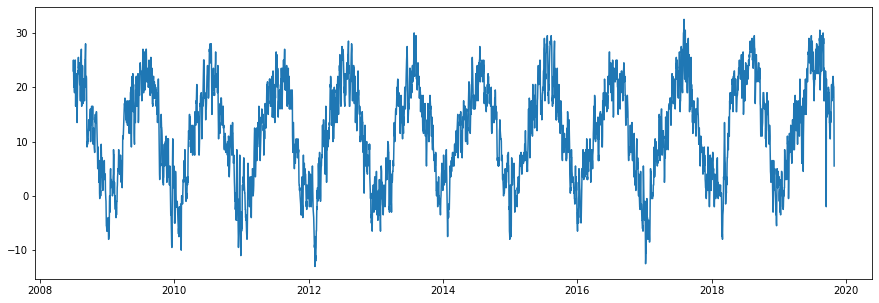

In [9]:
plt.figure( figsize= ( 15, 5))
plt.plot( target)

### Data splitting and scaling

First snippet splits the dataset to 3 parts: train, validation and test.
I specify the validation data here not in .fit() with validation_split because this way I can standardize it separately.

I'm not sure about standardization, make a scaler on the whole training set or make a scaler on every variable in the training set therefore I left the first approach in a commented cell but the second approch makes more sense to me.

In [10]:
val_split = .2
test_split = .1
num_data = len( data)

x_train = data[ 0:int( num_data*( 1 - val_split - test_split))]
x_val = data[ int( num_data*( 1 - val_split - test_split)):int( num_data*( 1 - test_split))]
x_test = data[ int( num_data*( 1 - test_split)):]

y_train = target[ 0:int( num_data*( 1 - val_split - test_split))]
y_val = target[ int( num_data*( 1 - val_split - test_split)):int( num_data*( 1 - test_split))]
y_test = target[ int( num_data*( 1 - test_split)):]

In [11]:
# x_scaler = preprocessing.StandardScaler().fit( x_train)
# x_train_sc = x_scaler.transform( x_train)
# x_val_sc = x_scaler.transform( x_val)
# x_test_sc = x_scaler.transform( x_test)

# y_scaler = preprocessing.MinMaxScaler().fit( y_train)
# y_train_sc = y_scaler.transform( y_train)
# y_val_sc = y_scaler.transform( y_val)
# y_test_sc = y_scaler.transform( y_test)

The for loop fits a standardization scaler on every variable in the training set than applies it on the appropriate column in validation and test sets. 

Returns a very large warning message about variable saving but unfortunately the bult-in inplace parameter doesn't work. 
I hide it for better readability.

Pandas DataFrame objects are converted to Numpy array for DL models.

In [38]:
warnings.filterwarnings('ignore')

for col in x_train.columns:
    scaler = preprocessing.StandardScaler().fit(x_train[[col]])
    x_train[[col]]=scaler.transform(x_train[[col]])
    x_val[[col]]=scaler.transform(x_val[[col]])
    x_test[[col]]=scaler.transform(x_test[[col]])
    
x_train_sc_FC = x_train.values
x_val_sc_FC = x_val.values
x_test_sc_FC = x_test.values
    
y_scaler = preprocessing.MinMaxScaler().fit(y_train.values.reshape(-1,1))
y_train_sc_FC = y_scaler.transform( y_train.values.reshape(-1,1))
y_val_sc_FC = y_scaler.transform( y_val.values.reshape(-1,1))
y_test_sc_FC = y_scaler.transform( y_test.values.reshape(-1,1))

warnings.filterwarnings('default')

I wasn't satisfied with the Fully Connected Network's accuracy and I was curious how accurate a Convolutional Neural Network is therefore I made both models for comparison.

I split the dataset to samples for CNN. One sample contains inputs from more than one time step and only one output value. (we will have to discard some values from the output time series).

The size (time period) of a sample can be specified with the interval_len variable.

In [13]:
interval_len = 3

In [14]:
def split_sample( x_var, y_var):
    x, y = list(), list()
    for i in range( len( x_var)):
        end_ix = i + interval_len
        if end_ix > len( x_var):
            break
        seq_x, seq_y = x_var[ i:end_ix, :], y_var[ end_ix-1, :]
        x.append( seq_x)
        y.append( seq_y)
    return np.array( x), np.array( y)

In [15]:
x_train_sc_CNN, y_train_sc_CNN = split_sample( x_train_sc_FC, y_train_sc_FC)
x_val_sc_CNN, y_val_sc_CNN = split_sample( x_val_sc_FC, y_val_sc_FC)
x_test_sc_CNN, y_test_sc_CNN = split_sample( x_test_sc_FC, y_test_sc_FC)

### Model building

Set up early stopping with patience of 30

In [16]:
from keras.callbacks import EarlyStopping
patience = 30
early_stopping = EarlyStopping( patience = patience, verbose = 1)

from keras.callbacks import ModelCheckpoint
checkpointer_FC = ModelCheckpoint( filepath = "weights_FC.hdf5",
                             save_best_only = True, 
                             verbose = 1 )

checkpointer_CNN = ModelCheckpoint( filepath = "weights_CNN.hdf5",
                             save_best_only = True, 
                             verbose = 1 )

### FC model

In [17]:
model_FC = Sequential()
model_FC.add( Dense( 5, input_shape = (x_train_sc_FC.shape[1],), activation = 'relu', kernel_initializer = 'random_uniform'))
model_FC.add( Dense( 4, input_shape = (x_train_sc_FC.shape[1],), activation = 'relu'))
model_FC.add( Dense( 4, input_shape = (x_train_sc_FC.shape[1],), activation = 'relu'))
model_FC.add( Dense( 4, input_shape = (x_train_sc_FC.shape[1],), activation = 'relu'))
model_FC.add( Dense( 1, activation = 'relu'))

model_FC.compile( loss = 'mean_squared_error', optimizer = 'adam')
model_FC.fit( x_train_sc_FC, y_train_sc_FC, 
          epochs = 100, 
          batch_size = 50, 
          validation_data = ( x_val_sc_FC, y_val_sc_FC),
          shuffle = False,
          callbacks = [ checkpointer_FC,early_stopping])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2896 samples, validate on 828 samples
Epoch 1/100
2896/2896 [==============================] - 0s 89us/step - loss: 0.2426 - val_loss: 0.1359

Epoch 00001: val_loss improved from inf to 0.13587, saving model to weights_FC.hdf5
Epoch 2/100
2896/2896 [==============================] - 0s 22us/step - loss: 0.0448 - val_loss: 0.0135

Epoch 00002: val_loss improved from 0.13587 to 0.01347, saving model to weights_FC.hdf5
Epoch 3/100
2896/2896 [==============================] - 0s 28us/step - loss: 0.0122 - val_loss: 0.0088

Epoch 00003: val_loss improved from 0.01347 to 0.00884, saving model to weights_FC.hdf5
Epoch 4/100
2896/2896 [==============================] - 0s 27us/step - loss: 0.0081 - val_loss: 0.0059

Epoch 00004: val_loss improved from 0.00884 to 0.00590, saving model to weights_FC.hdf5
Epoch 5/100
2896/2896 [==============================] - 0s 21us/

### CNN model

In [18]:
model_CNN = Sequential()
model_CNN.add( Conv1D( filters = 3, kernel_size = 2, kernel_initializer = 'random_uniform',
                       activation = 'relu', input_shape = ( interval_len, x_train_sc_CNN.shape[2])))
model_CNN.add( Conv1D( filters = 3, kernel_size = 2, kernel_initializer = 'random_uniform',
                       activation = 'relu', input_shape = ( interval_len, x_train_sc_CNN.shape[2])))
model_CNN.add( Flatten())
model_FC.add( Dense( 7, input_shape = ( x_train_sc_FC.shape[1],), activation = 'relu'))
model_FC.add( Dense( 4, input_shape = ( x_train_sc_FC.shape[1],), activation = 'relu'))

model_CNN.add( Dense( 1, activation = 'relu'))
model_CNN.compile( optimizer = 'adam', loss = 'mse')

model_CNN.fit( x_train_sc_CNN, y_train_sc_CNN, 
          epochs = 100,
          batch_size = 50,
          validation_data = ( x_val_sc_CNN, y_val_sc_CNN),
          shuffle = False,
          callbacks = [ checkpointer_CNN, early_stopping])

Train on 2894 samples, validate on 826 samples
Epoch 1/100
2894/2894 [==============================] - 0s 104us/step - loss: 0.2818 - val_loss: 0.2123

Epoch 00001: val_loss improved from inf to 0.21227, saving model to weights_CNN.hdf5
Epoch 2/100
2894/2894 [==============================] - 0s 34us/step - loss: 0.1004 - val_loss: 0.0351

Epoch 00002: val_loss improved from 0.21227 to 0.03507, saving model to weights_CNN.hdf5
Epoch 3/100
2894/2894 [==============================] - 0s 39us/step - loss: 0.0318 - val_loss: 0.0217

Epoch 00003: val_loss improved from 0.03507 to 0.02168, saving model to weights_CNN.hdf5
Epoch 4/100
2894/2894 [==============================] - 0s 39us/step - loss: 0.0225 - val_loss: 0.0153

Epoch 00004: val_loss improved from 0.02168 to 0.01526, saving model to weights_CNN.hdf5
Epoch 5/100
2894/2894 [==============================] - 0s 37us/step - loss: 0.0163 - val_loss: 0.0109

Epoch 00005: val_loss improved from 0.01526 to 0.01090, saving model to wei

### Comparison

Load the best model then calculate model predictions for MSE and visualization. 

It has to be noted that the last - forecast_period length - values in the target column are NaN's because of the time shifting therefore I cut them out where it's needed.

In [19]:
from keras.models import load_model

model_FC = load_model( 'weights_FC.hdf5')
model_CNN = load_model( 'weights_CNN.hdf5')

In [20]:
pred_FC = model_FC.predict( x_test_sc_FC)
pred_FC = y_scaler.inverse_transform( pred_FC)
targ_FC = y_scaler.inverse_transform( y_test_sc_FC)

pred_CNN = model_CNN.predict( x_test_sc_CNN)
pred_CNN = y_scaler.inverse_transform( pred_CNN)
targ_CNN = y_scaler.inverse_transform( y_test_sc_CNN)

In [21]:
from sklearn.metrics import mean_squared_error

test_mse_FC = mean_squared_error( targ_FC[ :-forecast_period], pred_FC[ :-forecast_period])
test_mse_CNN = mean_squared_error( targ_CNN[ :-forecast_period], pred_CNN[ :-forecast_period])

print('TEST MSE FC: %f' % ( test_mse_FC),'\nTEST MSE CNN: %f' % ( test_mse_CNN))

TEST MSE FC: 6.863209 
TEST MSE CNN: 6.199301


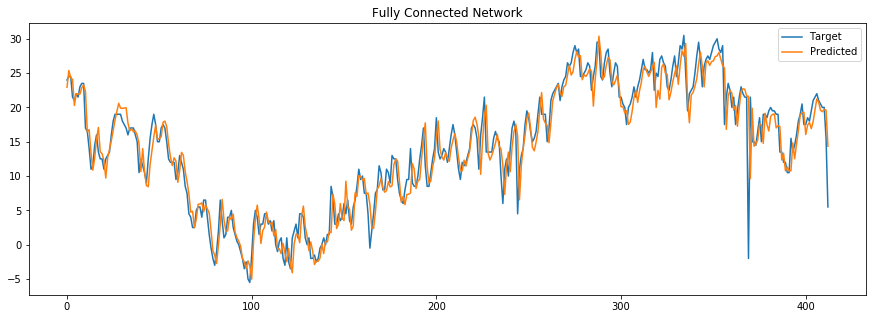

In [22]:
plt.figure( figsize= ( 15, 5))
plt.plot( targ_FC[ :-forecast_period])
plt.plot( pred_FC[ :-forecast_period])
plt.title( 'Fully Connected Network')
plt.legend( labels = [ 'Target', 'Predicted'])

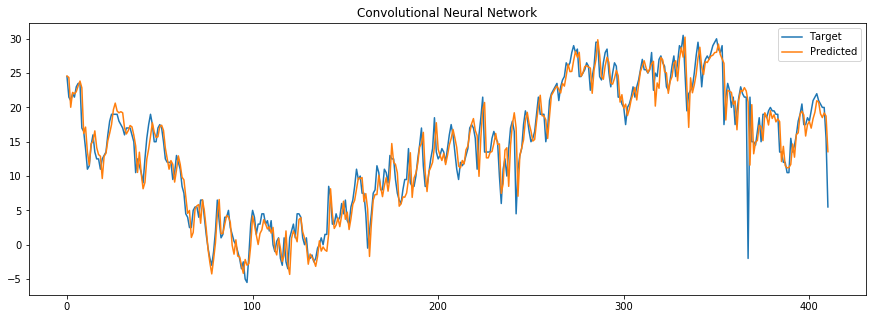

In [23]:
plt.figure( figsize= ( 15, 5))
plt.plot( targ_CNN[:-forecast_period])
plt.plot( pred_CNN[:-forecast_period])
plt.title('Convolutional Neural Network')
plt.legend( labels=['Target', 'Predicted'])

### Conclusion

The CNN network is usually a bit better than the FC but the hypermarameters influence the accuracy very strongly.

The prediction time interval is set in the beginning therefore the script must be re-run when we select 1 day, 7 day or 28 day. It always prints out the current estimated day's temperature that's why I write the needed estimations in a markdown cell.

In [24]:
print( 'FC prediction: %f °C' % ( pred_FC[-1]), '\nCNN prediction: %f °C' % ( pred_CNN[-1]))

FC prediction: 8.942622 °C 
CNN prediction: 7.969611 °C


  Estimated day   | FC            | CNN
  --------------- | ------------- | --------
  October 30      | 8.942622 °C   | 7.969611 °C
  November 5      | 10.062304 °C  | 9.946683 °C
  November 26     | 10.239018 °C  | 2.503098 °C